# Desarrollo memoria

### Importaciones de librerías

In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc

# 
import datetime

# Tensorflow GPU config
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Matplotlib setting
def set_chart_font():
    font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 16}
    import matplotlib
    matplotlib.rc('font', **font)

# Jupyter stuff
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 13pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

## Cargando el df

In [ ]:
# Se importa el dataset
df = pd.read_csv("./datasets/mediciones-netatmo-renam.csv") 

In [ ]:
display(df.head(5))
print(df.shape)
print("Mostrando los nulos")
display(df.isnull().sum())

Al ver el dataset se aprecia que hay 10169108 registros con 14 columnas cada uno. Resulta que la caracteristica sector indica 0 si es que la medicion es dentro de la casa o 1 si es que es fuera de ésta, para usos de esta memoria se determina que las mediciones dentro de la casa y fuera de esta deben de vivir en el mismo registro por lo que se carga el csv en una base de datos (postgres, ver anexo)  y se decide realizar dicha unificación, así es como se obtiene el nuevo dataset *'mediciones_unificadas.csv'*

In [2]:
try:
    del df
except:
    print("No hay df definido :(")
gc.collect()

df = pd.read_csv("./datasets/mediciones_unificadas.csv") 
# df.date_measured_at = pd.to_datetime(df.measured_at, unit='s')
df.date_measured_at = pd.to_datetime(df.date_measured_at)
df = df.drop(columns=['co2', 'ruido', 'dispositivo_id', 'measured_at'])

No hay df definido :(


In [ ]:
display(df.head(5))
print("INFO DE LOS DATOS")
display(df.describe())
print("CANTIDAD DE NULOS POR ATRIBUTO")
display(df.isnull().sum())
print(df.shape)
print("Viviendas distintas:",len(df.vivienda_id.unique()))

Ahora al ver el nuevo dataset unificado se aprecia que hay 4731498 registros, estos de un total de 303 viviendas distintas. Se aprecia que hay una gran cantidad de registros con dispositivo_id nulos, pero esto no es relevante ya que no es una variable a utilizar en el análisis. Hay unos pocos registros con nulos en variables revelantes como co2 y ruido (todo al interior de la casa)

Se va a proceder a sacar una muestra del orden del 10% de los datos para poder graficar las variables

In [ ]:
df_sample = df.sample(frac=0.03, replace=False, random_state=23)

In [ ]:
def temporada(a):
    fecha = pd.to_datetime(a)
    year = fecha.year
    otoño = (datetime.datetime(year, 3, 20), datetime.datetime(year, 6, 21))
    invierno = (datetime.datetime(year, 6, 21), datetime.datetime(year, 9, 23))
    primavera = (datetime.datetime(year, 9, 23), datetime.datetime(year, 12, 21))
    
    if otoño[0] <= fecha < otoño[1]:
        return "otoño"
    elif invierno[0] <= fecha < invierno[1]:
        return "invierno"
    elif primavera[0] <= fecha < primavera[1]:
        return "primavera"
    else:
        return "verano"
    
df_sample['epoca'] = np.vectorize(temporada)(df_sample['date_measured_at'])

In [ ]:
print("Mostrando la forma de la muestra")
print(df_sample.shape)

In [ ]:
# VARIABLES = ['temperatura_interior', 'temperatura_exterior', 'humedad_interior', 'humedad_exterior', 'co2', 'ruido']
VARIABLES = ['temperatura_interior', 'temperatura_exterior', 'humedad_interior', 'humedad_exterior']
sns.set_context("paper", font_scale=1.5) 
sns.pairplot(df_sample, vars=VARIABLES, height=3, dropna=True, hue="epoca", diag_kind="hist", aspect=4/3)

Al ver el gráfico del cruce de todas las variables se aprecia lo siguiente
- **Temperatura interior:** Se relaciona con la temperatura exterior y la humedad interior
- **Temperatura exterior:** Se relaciona con humedad exterior y temperatura interior
- **Humedad interior:** Se relaciona con temperatura interior
- **Humedad exterior:** Se relaciona con temperatura interior
- **Humedad interior:** Se relaciona con temperatura exterior

Al ver el co2 y el ruido no se aprecia alguna relacion aparente.


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

for i in range(len(VARIABLES)):
    sns.distplot(df_sample[VARIABLES[i]].dropna(), hist=True, kde=False, ax=ax[i])
    
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(25,5))

for i in range(len(VARIABLES)):
    sns.boxplot(x=df_sample[VARIABLES[i]].dropna(), ax=ax[i], orient="h")

## Deteccción de outliers multi-variado

https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

In [ ]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
display(df_sample.head())
print(df_sample.shape)

In [ ]:
# Se trasnforma la data para que quede toda junta
x1 = df_sample['temperatura_interior'].values.reshape(-1,1)
x2 = df_sample['humedad_interior'].values.reshape(-1,1)
x3 = df_sample['temperatura_exterior'].values.reshape(-1,1)
x4 = df_sample['humedad_exterior'].values.reshape(-1,1)

X = np.concatenate((x1,x2, x3, x4),axis=1)

In [ ]:
def getOutliers(model, X):
    # Anormality score
    # scores_pred = model.decision_function(X) * -1
    y_pred = model.predict(X)
    
    # Muestra por pantalla el número de outliers
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    print('OUTLIERS : ', n_outliers,'INLIERS : ',n_inliers)
    return y_pred

In [ ]:
# Porcentage de outliers en la muestra
OUTLIERS_FRACTION = 0.05

model = IForest(contamination=OUTLIERS_FRACTION, random_state= 22, behaviour='new')
model.fit(X)

outlierIndex = getOutliers(model, X)

## Rellenado de data faltante

In [3]:
HASH_OF_TIME_SERIES = {}

TARGET_DF = df

# TODO: Ver que está pasando entre lo que dice el segundo y la fecha
# TARGET_DF.date_measured_at = pd.to_datetime(TARGET_DF.measured_at, unit='s')
display(TARGET_DF.head())

for i, g in TARGET_DF.groupby('vivienda_id'):
    HASH_OF_TIME_SERIES[i] = g.set_index('date_measured_at')
    
display(HASH_OF_TIME_SERIES[2].head())

,id,vivienda_id,temperatura_interior,humedad_interior,temperatura_exterior,humedad_exterior,date_measured_at
0,1,3,26.3,48,27.5,35,2015-11-26 20:30:00
1,2,3,25.2,47,25.4,35,2015-11-26 21:00:00
2,3,3,23.9,45,23.4,38,2015-11-26 21:30:00
3,4,3,23.3,46,22.4,38,2015-11-26 22:00:00
4,5,3,24.0,46,21.5,39,2015-11-26 22:30:00


,id,vivienda_id,temperatura_interior,humedad_interior,temperatura_exterior,humedad_exterior
date_measured_at,,,,,,
2016-01-01 03:00:00,3084,2,25.0,46,21.5,48
2016-01-01 03:30:00,3089,2,24.9,45,21.5,47
2016-01-01 04:00:00,3094,2,24.8,45,21.7,46
2016-01-01 04:30:00,3099,2,24.5,45,21.7,46
2016-01-01 05:00:00,3104,2,24.2,45,21.4,46


In [ ]:
houses_to_work_count = 0
for i in HASH_OF_TIME_SERIES.keys():
    temp = HASH_OF_TIME_SERIES[i].resample('30min').mean()
    missing_rate = (temp.isna().sum()/len(temp) * 100).temperatura_interior
    if missing_rate <= 10:
        houses_to_work_count+=1
        print("Casa {}, Porcentage de null: {}%".format(i, missing_rate))
        
print("Cantidad de casas con las que trabajar:", houses_to_work_count)
print("Total casas:", len(HASH_OF_TIME_SERIES.keys()))

In [ ]:
display(HASH_OF_TIME_SERIES[2].resample('30min').mean().head())

In [ ]:
import math

HOUSE_IN_STUDY = 2#16

temp = HASH_OF_TIME_SERIES[HOUSE_IN_STUDY].resample('30min').mean()
lakes = []
lake=[]
in_lake = False

inicio = True
fechas = []

for index, row in temp.iterrows():
    
    temperatura = getattr(row, 'temperatura_interior')
    fecha = index
    
    if inicio:
        fechas.append(fecha)
        inicio = False
    
    # Caso en que se inicia una laguna
    if math.isnan(temperatura) and not in_lake:
        in_lake = True
        lake.append(fecha)
        
    # Caso termina laguna
    elif in_lake and not math.isnan(temperatura):
        in_lake = False
        lake.append(fecha)
        lakes.append(lake)
        lake = list()
        
fechas.append(index)

In [ ]:
print(fechas)
for x, y in lakes:
    print(y-x)
    
if len(lakes) == 0:
    print("Está llena al 100%")

In [ ]:
HASH_OF_TIME_SERIES.keys()

## Armando la matriz

In [ ]:
display(HASH_OF_TIME_SERIES[2].head(3))
print(HASH_OF_TIME_SERIES[2].shape)

Voy a proceder a escalar los datos con un escalador robusto a outliers

In [4]:
from sklearn.preprocessing import RobustScaler

FEATURES_IN_STUDY = ["temperatura_interior", "humedad_interior", "temperatura_exterior", "humedad_exterior"]
# TRAIN_LENGTH = int(HASH_OF_TIME_SERIES[2].shape[0] * 0.8)

# TODO: Quizá re pensar esto por temas de memoria un diccionario no es lo mejor
# por cada casa se necesita 1 diccionario con los 4 Escalers
# scalers_dict = dict()
# scalers_dict[2] = {'temperatura_interior': RobustScaler(), 'humedad_interior': RobustScaler(), 'temperatura_exterior': RobustScaler(), 'humedad_exterior': RobustScaler()}

def standarize_train(serie_df):
    scalers_dictionary = dict()
    
    # Se pone un RobustScaler por cada feature
    for i in FEATURES_IN_STUDY:
        scalers_dictionary[i] = RobustScaler()
    
    copy = serie_df.copy()
    
    for column_name in FEATURES_IN_STUDY:
        # Se le hace fit al scaler
        scalers_dictionary[column_name].fit( np.expand_dims(copy[column_name], axis=1))

        # Se transforma la data
        copy[column_name] = scalers_dictionary[column_name].transform( np.expand_dims(copy[column_name], axis=1) )

    return (copy, scalers_dictionary)

def standarize_val(serie_df, scalers_dictionary):
    copy = serie_df.copy()
    for column_name in FEATURES_IN_STUDY:
        # Se transforma la data
        copy[column_name] = scalers_dictionary[column_name].transform(np.expand_dims(copy[column_name], axis=1))
        
    return copy

# a , example_of_scalers = standarize_train( HASH_OF_TIME_SERIES[2][0:TRAIN_LENGTH] )
# a_val = standarize_val( HASH_OF_TIME_SERIES[2][TRAIN_LENGTH:], example_of_scalers )

# display(a.head())
# display(a.describe())

In [5]:
def generate_lag(serie_df, lag):
    X = list()
    Y = list()
    last_seen = list()
    
    for index, row in serie_df.iterrows():
        
        current_record = list()
        
        for i in FEATURES_IN_STUDY:
            current_record.append(row[i])
        
        # current_record = [row['temperatura_interior'], row['humedad_interior'], row['temperatura_exterior'], row['humedad_exterior']]
        
        # print(current_record)
        
        if len(last_seen) < lag:
            last_seen.append(current_record)
            
        else:
            # print("Mostrando current_record:", current_record)
            
            # print("Mostrando last_seen:",last_seen)
            Y.append(list(current_record))
            X.append(list(last_seen))
            
            # print("Mostrando x", X)
            # print("Mostrando y", Y)
            
            del last_seen[0]
            last_seen.append(current_record)
            
    return np.asarray(X),np.asarray(Y)
                                   
AMOUNT_OF_LAG = 3
    
# X_train, Y_train = generate_lag(a, AMOUNT_OF_LAG)  
# X_val, Y_val = generate_lag(a_val, AMOUNT_OF_LAG)  

# print("Train:",X_train.shape,"Val:",X_val.shape)

In [14]:
# Entra el pandas df de la cada en particular
TRAIN_PERCENTAGE = 0.8
def generate_matrix(serie_df):
    TRAIN_LENGTH = int(serie_df.shape[0] * TRAIN_PERCENTAGE)
    
    train_df , scalers_dictionary = standarize_train( serie_df[0:TRAIN_LENGTH] )
    val_df = standarize_val( serie_df[TRAIN_LENGTH:], scalers_dictionary )

    AMOUNT_OF_LAG = 3
    
    X_train, Y_train = generate_lag(train_df, AMOUNT_OF_LAG)  
    X_val, Y_val = generate_lag(val_df, AMOUNT_OF_LAG)
    
    return ( (X_train, Y_train), (X_val, Y_val), scalers_dictionary )

train_data, valitation_data, scalers = generate_matrix(HASH_OF_TIME_SERIES[2])
print(train_data[0].shape)
print(valitation_data[0].shape)

(34110, 3, 4)
(8526, 3, 4)


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, TimeDistributed, CuDNNGRU, GRU

model = Sequential()

# Recurrente
model.add(CuDNNGRU(input_shape=(AMOUNT_OF_LAG, 4), units=100, return_sequences=False))

# FF
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['mean_absolute_percentage_error'])  
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 100)               31800     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 61,756
Trainable params: 61,756
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_data[0], train_data[1], validation_data=(valitation_data[0], valitation_data[1]), epochs=15, batch_size=256, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 34110 samples, validate on 8526 samples
Epoch 1/15
34110/34110 [==============================] - 2s 67us/step - loss: 0.0323 - val_loss: 0.0077
Epoch 2/15
34110/34110 [==============================] - 0s 12us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/15
34110/34110 [==============================] - 0s 12us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 4/15
34110/34110 [==============================] - 1s 15us/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/15
34110/34110 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0034
Epoch 6/15
34110/34110 [==============================] - 1s 16us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 7/15
34110/34110 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0030
Epoch 8/15
34110/34110 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 9/15
34110/34110 [==============================] - 1s 15

In [10]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


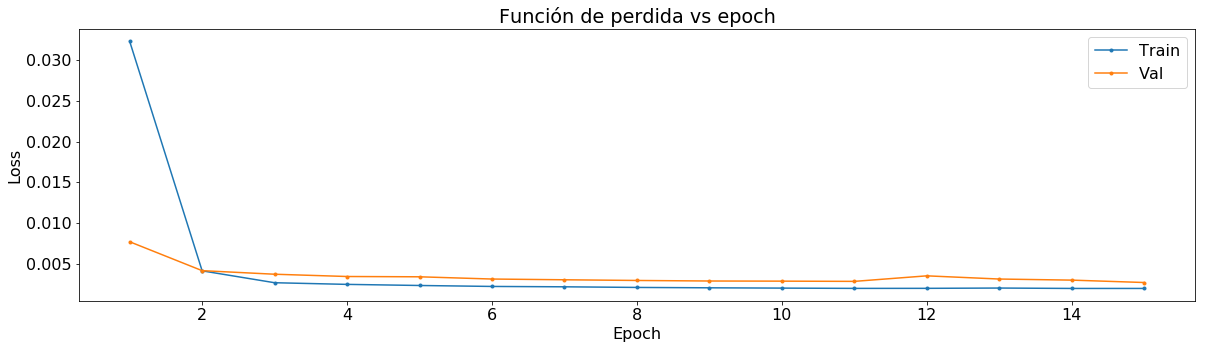

In [11]:
def chart_loss(history, epoch_number):
    set_chart_font()
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    # plt.plot(epoch_arr, history.history['val_mean_absolute_percentage_error'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val', 'MAE') )
    plt.title("Función de perdida vs epoch")

    # min_index = np.argmin(history.history['val_loss'])
    # min_value = history.history['val_mean_absolute_percentage_error'][min_index].round(3)
    # plt.annotate('Min = {}'.format(min_value), xy=(min_index+1, min_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history, 15)

In [12]:
y_pred = model.predict(valitation_data[0])

/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


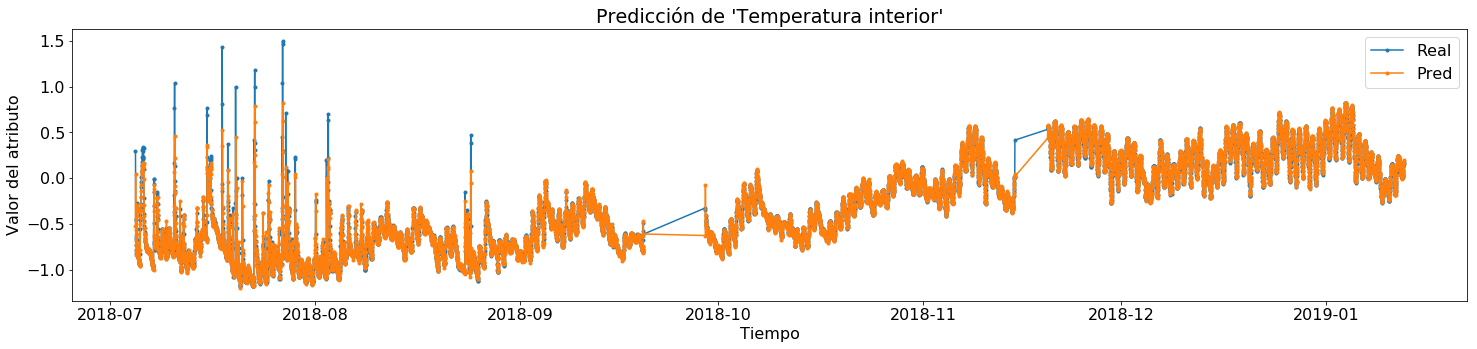

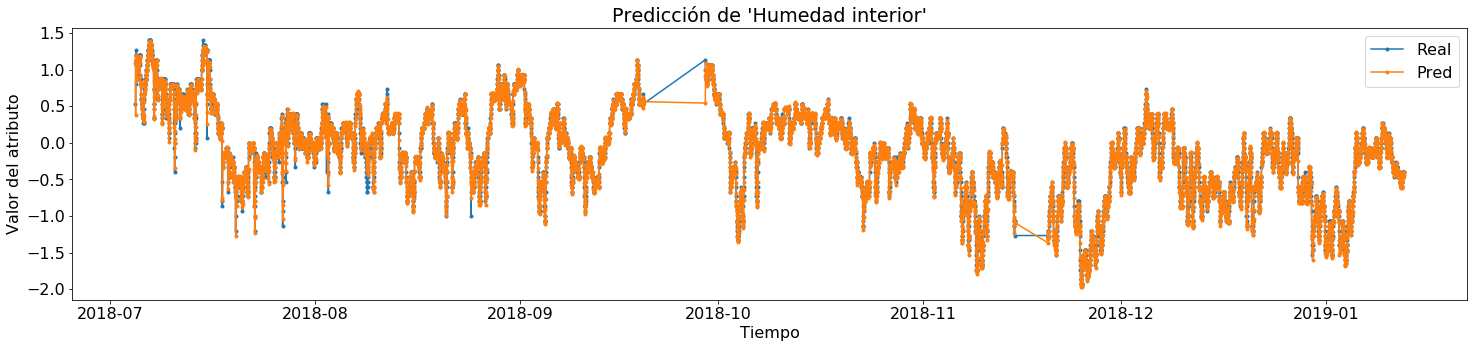

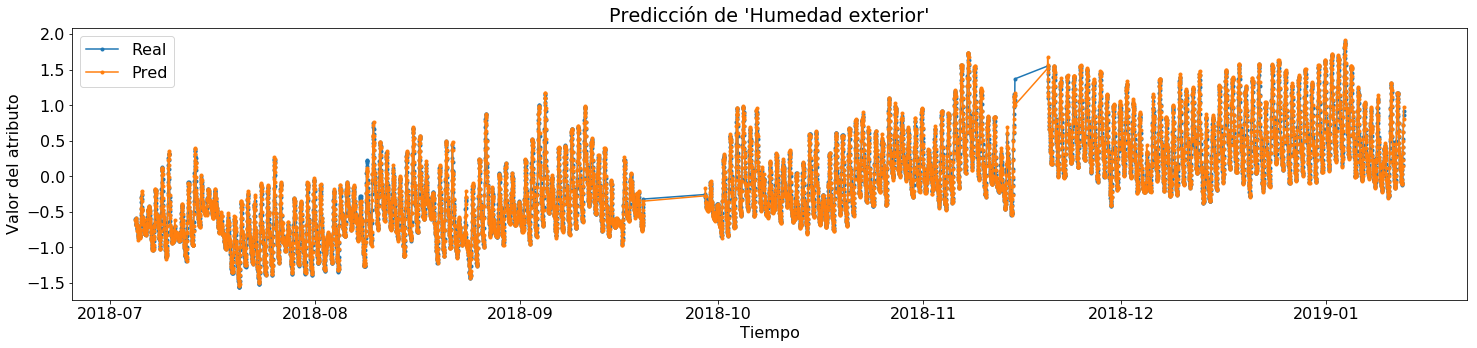

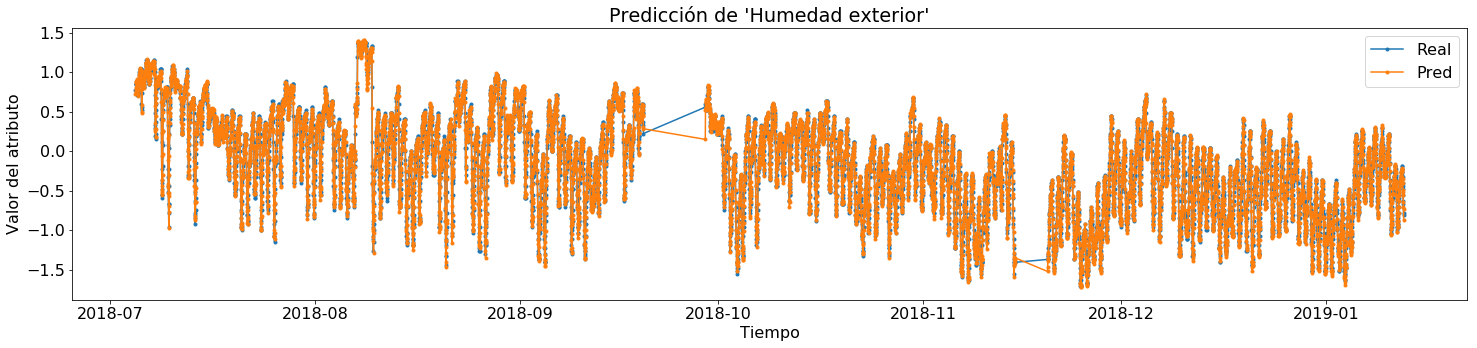

In [18]:
def chart_predictions(serie_df, column_target, truth, pred):
    set_chart_font()
    plt.figure(figsize = (25,5))
    title_format="Predicción de '{}'"
    
    if column_target == 0:
        variable_name = "Temperatura interior"
    elif column_target == 1:
        variable_name = "Humedad interior"
    elif column_target == 1:
        variable_name = "Temperatura exterior"
    else:
        variable_name= "Humedad exterior"
        
    TRAIN_LENGTH = int(serie_df.shape[0] * TRAIN_PERCENTAGE)
    
    time = list(serie_df[TRAIN_LENGTH+AMOUNT_OF_LAG:].index)
    
    plt.plot(time, truth[:,column_target], '.-')
    plt.plot(time, pred[:,column_target], '.-')
    
    plt.xlabel('Tiempo')
    plt.ylabel('Valor del atributo')
    plt.legend( ('Real', 'Pred') )
    plt.title( title_format.format(variable_name) )
    
    plt.show()
    
for i in range(4):
    chart_predictions(HASH_OF_TIME_SERIES[2], i, valitation_data[1], y_pred)

## Caracterización casas

In [ ]:
df_casas = pd.read_csv("./datasets/RENAM_encuesta_inicial.csv")

In [ ]:
# Se pasa el vivienda_id
def clean_id( x ):
    return int(x[2:])
   
df_casas['vivienda_id'] = np.vectorize(clean_id)(df_casas['ID'])

In [ ]:
print(df_casas.shape)
df_casas.head(3)

Voy a armar varios grupos con caracterizaciones tipo para ver de que tamaño quedan los grupos

In [ ]:
print("- Ciudades")
display(df_casas.groupby(['Ciudad']).count()[['vivienda_id']])

print("- Año de contrucción")
display(df_casas.groupby(['Año de construcción de la vivienda']).count()[['vivienda_id']])

# print("- Personas en la casa")
# display(df_casas.groupby(['N° de personas que componen el hogar (incluyendo el encuestado)']).count()[['vivienda_id']])

print("- Origen de la vivienda")
display(df_casas.groupby(['¿Cuál es el origen de su vivienda?']).count()[['vivienda_id']])

print("- Ciudad + Año de contrucción")
display(df_casas.groupby(['Año de construcción de la vivienda', 'Ciudad', '¿Cuál es el origen de su vivienda?']).count()[['vivienda_id']])

In [ ]:
i = 0
for x in df_casas.columns:
    print("{}, {}".format(i, x))
    i+=1

In [ ]:
relevant = [0, 2, 3, 4, 5, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 52, 53, 54, 66, 67, 73, 74, 75, 76]

# Ahora en la segunda 'iteración'
relevant2 = []

# Datos que me quedaron con duda 25 al 30

df_relevant = df_casas.iloc[:, relevant]

In [ ]:
for x in df_relevant.columns:
    uniq = df_relevant[x].unique()
    print("=== {}: {} ===".format(x, len(uniq)))
    print(uniq)

In [ ]:
display(df_relevant.isnull().sum())

## Anexo: Importar dataset a bd en postgres

In [ ]:
# Código que importa el csv a postgres
import psycopg2

def export_to_db():
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "abc123",
                                      host = "127.0.0.1",
                                      port = "5432",
                                      database = "memoria")
        cursor = connection.cursor()

        insert_rows_format = '''
        insert into mediciones_netatmo
        (dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
        values ({}, {}, {}, {}, {}, {}, {}, {}, '{}'),
        '''
        row_format = "({}, {}, {}, {}, {}, {}, {}, {}, '{}')"
        i = 0
        for row in df.itertuples(index=True, name='Pandas'):
            # print getattr(row, "c1"), getattr(row, "c2")

            sector = False

            dispositivo_id = getattr(row, 'dispositivo_id')
            vivienda_id = getattr(row, 'vivienda_id')

            if getattr(row, 'sector') == 1:
                sector = True

            temperatura = getattr(row, 'temperatura')
            humedad = getattr(row, 'humedad')
            co2 = getattr(row, 'co2')
            ruido = getattr(row, 'ruido')
            measured_at = getattr(row, 'measured_at')
            date_measured_at = pd.to_datetime(measured_at, unit='s')

            if i == 0:
                SQL = insert_rows_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
            elif i < 20000:
                SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)+","
            else:
                SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
                SQL = SQL.replace("nan", "NULL")
                cursor.execute(SQL)
                connection.commit()
                SQL = ""
                i = -1
            i+=1

        if SQL != "":
            SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
            SQL = SQL.replace("nan", "NULL")
            cursor.execute(SQL)
            connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
                
# export_to_db()